# IQ Imbalance and Correction

In quadrature modulation schemes, there are two streams of signals multiplexed into the same RF bandwidth: the in phase component (I) and the quadrature component (Q). Many modern receivers implement a direct downconversion architecture that looks like this:

<img src="ddr.png"/>

A single local oscillator is used to feed two mixers. One of the mixers is fed a signal 90 degrees phase shifted compared to the other, thus performing quadrature downconversion. However, due to different component properties and the environment, the downconversion may not be ideal. There is usually an offset in the phase and amplitude of the two signals that feed into the mixers. This is a serious hindrance in a radio frequency front-end, since such an imbalance causes image interference. If left uncorrected, the image interference will cause an error floor that impedes the performance of the system. This phenomenon is even more pronounced in wide bandwidth mixers as the oscillator/mixer response may vary slightly over the bandwidth of interest.

## Modelling IQ imbalance

Assume $I(t)$ and $Q(t)$ respectively are the I and Q components of the local oscillator that drives each of the mixers. Ideally, we should have:

$$
I(t) = cos(\omega t)
\\ Q(t) = sin(\omega t)
$$

However, due to imbalance effects, there is a scaling, phase offset and some DC bias introduced. We now have:

$$
I'(t) = \alpha cos(\omega t) + { \beta  }_{ I }
\\ Q'(t) = sin(\omega t+\psi ) + { \beta  }_{ Q }
$$

${ \beta  }_{ I }$ and ${ \beta  }_{ Q }$ are the DC offsets in each of the signals. $\alpha$ is the amplitude offset and $\psi$ is the phase offset. For the time being, let us ignore the DC offsets (we will see later that they can be calibrated out). We now have:

$$
I''(t) = \alpha cos(\omega t)
\\ Q''(t) = sin(\omega t+\psi )
$$

To recover $I(t)$ and $Q(t)$ from the above, we write down simplified trigonometric equations and note that:

$$
\begin{bmatrix} I''(t) \\ Q''(t) \end{bmatrix}=\begin{bmatrix} \alpha  & 0 \\ sin(\psi ) & cos(\psi ) \end{bmatrix}\begin{bmatrix} I(t) \\ Q(t) \end{bmatrix}
$$

Therefore, if we know the values of $\alpha$ and $\psi$, we can invert the 2x2 matrix above to get:

$$
\begin{bmatrix} I(t) \\ Q(t) \end{bmatrix}=\begin{bmatrix} { \alpha  }^{ -1 } & 0 \\ { -\alpha  }^{ -1 }tan(\psi ) & sec(\psi ) \end{bmatrix}\begin{bmatrix} I''(t) \\ Q''(t) \end{bmatrix}
$$

We can now easily include the DC offset calibration into the model as follows:

$$
\begin{bmatrix} I(t) \\ Q(t) \end{bmatrix}=\begin{bmatrix} { \alpha  }^{ -1 } & 0 \\ { -\alpha  }^{ -1 }tan(\psi ) & sec(\psi ) \end{bmatrix}\begin{bmatrix} I''(t)-{ \beta  }_{ I } \\ Q''(t)-{ \beta  }_{ Q } \end{bmatrix}
$$

We can now abstract out the effects of $\alpha$ and $\psi$, and interpret the above equation as follows:

$$
\begin{bmatrix} I(t) \\ Q(t) \end{bmatrix}=\begin{bmatrix} A & 0 \\ C & D \end{bmatrix}\begin{bmatrix} I''(t)-{ \beta  }_{ I } \\ Q''(t)-{ \beta  }_{ Q } \end{bmatrix}
$$

The values of $A,C$ and $D$ are usually computed by looking at the downconverted signal of a known transmitted signal. Usually, radio frontends can self calibrate to find all the unknowns in the above equation and load the matrix inverse for future use.

1. Some theory on computing these values can be found here: https://www.faculty.ece.vt.edu/swe/argus/iqbal.pdf
2. USRP Self Calibration: https://files.ettus.com/manual/page_calibration.html

Let us now look at how IQ imbalance effects signals through a programming exercise.

In [292]:
# The below is a command to force the ipynb to plot inline instead of popping a window
%matplotlib inline
import numpy as np
import numpy.matlib
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# We'll illustrate the effect of IQ imbalance using plain complex sinusoids
fs = 2000;
ts = 1.0/fs;

t = np.arange(0,2,ts);
f = np.arange(-1000,1000,1/2);

# Baseband signal (sine wave)
f_b = 10;
x_b = np.cos(2*np.pi*f_b*t) + 1j*np.sin(2*np.pi*f_b*t)

# Transmit carrier oscillator model
f_tx = 200
cos_tx = np.cos(2*np.pi*f_tx*t);
sin_tx = np.sin(2*np.pi*f_tx*t);
mixer_tx = cos_tx + 1j*sin_tx;

# Upconversion
x_tx = np.multiply(x_b,mixer_tx);

# Receive carrier oscillator model
# psi and alpha may be changed
psi = np.pi/5;
alpha = 0.9;
cos_rx = alpha*np.cos(2*np.pi*f_tx*t );
sin_rx = np.sin(2*np.pi*f_tx*t + psi);
mixer_rx = cos_rx - 1j*sin_rx;
# Downconversion
x_rx = np.multiply(x_tx,mixer_rx);

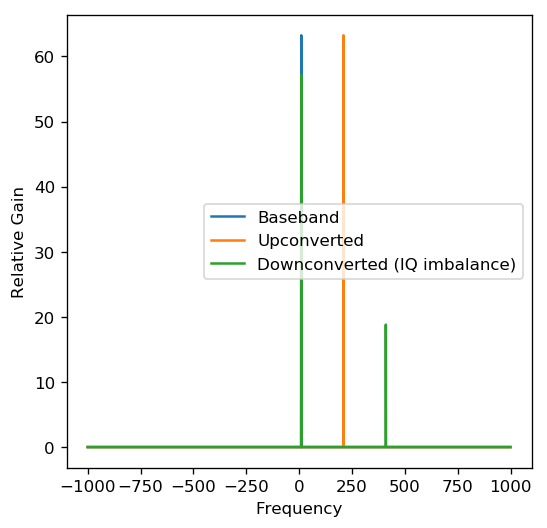

In [293]:
# Plotting

fig = plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k');
plt.plot(f,abs(np.fft.fftshift(np.fft.fft(x_b,norm="ortho"))));
plt.plot(f,abs(np.fft.fftshift(np.fft.fft(x_tx,norm="ortho"))));
plt.plot(f,abs(np.fft.fftshift(np.fft.fft(x_rx,norm="ortho"))));
plt.legend(['Baseband','Upconverted','Downconverted (IQ imbalance)']);
plt.xlabel('Frequency');
plt.ylabel('Relative Gain');

In the above plot, there is an added frequency component after downconversion. The signal's "image" has appeared because of IQ imbalance. Try changing the values of ``psi`` and ``alpha`` to observe the effects.

In the figure below, we compare the Lissajous figures of the two oscillators. The Tx oscillator has a perfect phase shift and is circular. The Rx Oscillator is an ellipsoid due to the offsets introduced.

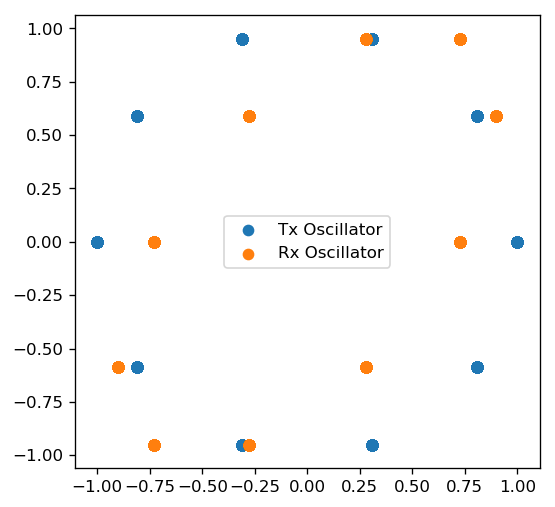

In [294]:
# Comparing the Oscillator Lissajous figures
fig = plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
plt.scatter(cos_tx,sin_tx);
plt.scatter(cos_rx,sin_rx);
plt.legend(['Tx Oscillator','Rx Oscillator']);

## Exercises

### Q1

Find the matrix that inverts the effects of the Rx oscillator for the configuration given above.

In [295]:
# Q1 code

### Q2

Using the matrix from Q1, recover the original signal by applying the correction after downconversion.

In [296]:
# Q2 code

### Q3

Do Q1 and Q2 for the following oscillator model:

In [297]:
psi = np.pi/5;
alpha = 0.9;
cos_rx = alpha*np.cos(2*np.pi*f_tx*t ) + 0.01;
sin_rx = np.sin(2*np.pi*f_tx*t + psi) - 0.02;
mixer_rx = cos_rx - 1j*sin_rx;

# Q3 code

## References

1. Correcting I-Q Imbalance in Direct Conversion Receivers: https://www.faculty.ece.vt.edu/swe/argus/iqbal.pdf
2. Analog Devices Wiki: https://wiki.analog.com/resources/eval/user-guides/ad-fmcomms1-ebz/iq_correction
3. USRP Device Calibration, Ettus Research: https://files.ettus.com/manual/page_calibration.html